In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import re
import csv
from sklearn.preprocessing import LabelEncoder
import nltk
from nltk.corpus import stopwords
from collections import Counter 
import string
from nltk.tokenize import word_tokenize
from langdetect import detect
nltk.download("vader_lexicon")
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from scipy import stats
import statsmodels.api
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/merlekuehlenborg/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
#Loading the dataset
pd.set_option('display.max_rows', None) 
pd.set_option('display.max_columns', None)

df_trustpilot = pd.read_csv('data/data_trustpilot_first.csv', engine='python')

#Displaying basic information
print(df_trustpilot.columns)
print(df_trustpilot.info())
display(df_trustpilot.head())


Index(['username', 'number_reviews', 'location', 'rating', 'text',
       'date_of_experience', 'date_posted', 'verification', 'subject',
       'answer', 'company'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78404 entries, 0 to 78403
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   username            78401 non-null  object
 1   number_reviews      78404 non-null  int64 
 2   location            78404 non-null  object
 3   rating              78404 non-null  int64 
 4   text                78404 non-null  object
 5   date_of_experience  78404 non-null  object
 6   date_posted         78404 non-null  object
 7   verification        78404 non-null  object
 8   subject             78404 non-null  object
 9   answer              78404 non-null  object
 10  company             78404 non-null  object
dtypes: int64(2), object(9)
memory usage: 6.6+ MB
None


,username,number_reviews,location,rating,text,date_of_experience,date_posted,verification,subject,answer,company
0,Rob Crane,2,CA,5,The company rep I worked with made my transact...,2024-06-15,2024-10-23 04:17:44,Redirected,The company rep I worked with made my…,0,Flashbay
1,Pat Anderson,1,US,5,I highly recommend using Flashbay. Immediately...,2024-10-16,2024-10-16 19:34:05,Verified,I highly recommend using Flashbay,0,Flashbay
2,Margarita Orlova,1,CZ,5,I had the pleasure of working with Shelby Gibs...,2024-10-10,2024-10-17 10:27:44,Verified,Great customer service,0,Flashbay
3,Paola Rivas,1,US,5,I had a fantastic experience with Brian Truong...,2024-10-21,2024-10-21 22:38:50,Verified,Outstanding Support and Attentive Service,0,Flashbay
4,Fiona Mckelvey Keenan,3,CA,5,My number-one go-to for computer accessories. ...,2024-07-11,2024-10-23 04:09:05,Not Verified,My number-one go-to for computer…,0,Flashbay


STAGE 1 - CREATING NEW COLUMNS

In [3]:
#convert date_posted and date_of_experience to datetime
df_trustpilot['date_posted'] = pd.to_datetime(df_trustpilot['date_posted'])
df_trustpilot['date_of_experience'] = pd.to_datetime(df_trustpilot['date_of_experience'])

#Create local_hour and local_date_posted
#Fixing the date_posted column
#The date_posted is from the CET timezone, however, there are countries in the list that are in a different timezone.
#That way, if someone posts at 9 pm in New York City, it appears as 3 am CET, potentially skewing the data.
#We need to fix this column so that date_posted represents the original date and time posted, from the view of the user writing the review.
#Maps the timezone difference from the view of the CET timezone

timezone_offsets = {
    # Western Europe (CET/CEST)
    'DE': 0, 'FR': 0, 'IT': 0, 'ES': 0, 'NL': 0, 'BE': 0, 'AT': 0, 'CH': 0, 'SE': 0,
    'DK': 0, 'NO': 0, 'PL': 0, 'CZ': 0, 'PT': 0, 'HU': 0, 'SK': 0, 'SI': 0, 'LU': 0,
    'MT': 0, 'HR': 0, 'BA': 0, 'AL': 0, 'ME': 0, 'RS': 0, 'MK': 0, 'AD': 0, 'LI': 0,
    # Eastern Europe
    'FI': 1, 'EE': 1, 'LV': 1, 'LT': 1, 'UA': 1, 'RO': 1, 'BG': 1, 'GR': 1, 'BY': 1,
    'MD': 1, 'TR': 1, 'CY': 1,
    # UK and related territories
    'GB': -1, 'IE': -1, 'IM': -1, 'JE': -1, 'GG': -1, 'GI': -1,
    # Russia and Central Asia
    'RU': 3, 'KZ': 4, 'UZ': 5, 'KG': 5,
    # North America and Greenland
    'US': -7, 'CA': -7, 'MX': -7, 'PR': -6, 'VI': -6, 'GU': 10, 'GL': -3,  
    # Central America and Caribbean
    'GT': -8, 'HN': -8, 'SV': -8, 'NI': -8, 'CR': -8, 'PA': -7,
    'BS': -7, 'CU': -7, 'JM': -7, 'DO': -6, 'BB': -6, 'TT': -6,
    'KN': -6, 'AG': -6, 'VC': -6, 'AI': -6, 'BM': -6, 'KY': -6,
    'TC': -6, 'AW': -6, 'CW': -6, 'BQ': -6, 'SX': -6, 'GP': -6,
    # South America
    'BR': -5, 'AR': -5, 'CL': -6, 'CO': -7, 'VE': -6, 'PE': -7,
    'EC': -7, 'BO': -6, 'PY': -6, 'UY': -5,
    # East Asia
    'CN': 7, 'JP': 8, 'KR': 8, 'TW': 7, 'MN': 7, 'HK': 7, 'MO': 7,
    # Southeast Asia
    'SG': 7, 'MY': 7, 'ID': 7, 'TH': 7, 'VN': 7, 'PH': 7,
    'MM': 6.5, 'KH': 7, 'BN': 7,
    # South Asia
    'IN': 4.5, 'PK': 4, 'BD': 5, 'NP': 4.75, 'LK': 4.5, 'MV': 4,
    # Central Asia and Middle East
    'AE': 3, 'SA': 2, 'IL': 2, 'IR': 2.5, 'IQ': 2, 'OM': 3,
    'KW': 2, 'QA': 2, 'BH': 2, 'JO': 2, 'LB': 2, 'AF': 3.5,
    'AM': 3, 'AZ': 3, 'GE': 3,
    # Oceania
    'AU': 9, 'NZ': 11, 'FJ': 11, 'PF': 10, 'MP': 9,
    # Africa
    'ZA': 1, 'EG': 1, 'MA': 0, 'DZ': 0, 'TN': 0, 'LY': 1,
    'NG': 0, 'GH': 0, 'KE': 2, 'UG': 2, 'RW': 1, 'CD': 1,
    'GA': 0, 'CM': 0, 'ZW': 1, 'CI': 0, 'SS': 2,  
    'RE': 3,  
    # European Islands and Territories
    'IS': -1, 'FO': -1, 'AX': 1,
    # Disputed or Special Territories
    'XK': 0}

#Checking whether there are countries missing in our dictionary that are present in our df
countries_in_df = df_trustpilot['location'].unique()
countries_in_mapping = set(timezone_offsets.keys())
missing_countries = set(countries_in_df) - countries_in_mapping
if len(missing_countries) > 0:
    print("Countries in dataset but not in timezone mapping:")
    print(missing_countries)
    print(f"Total missing countries: {len(missing_countries)}")
else:
    print("All countries in the dataset are covered in our timezone mapping!")

#Creating new columns local_hour and local_date_posted
def adjust_to_local_time(df_trustpilot):
    df_trustpilot['local_hour'] = None
    df_trustpilot['local_date_posted'] = None
    for country_code, offset in timezone_offsets.items():
        mask = df_trustpilot['location'] == country_code
        if offset != 0:  
            local_datetime = pd.to_datetime(df_trustpilot.loc[mask, 'date_posted']) + pd.Timedelta(hours=offset)
            df_trustpilot.loc[mask, 'local_date_posted'] = local_datetime.dt.date
            df_trustpilot.loc[mask, 'local_hour'] = local_datetime.dt.hour
    
    # Processing CET countries (offset = 0)
    cet_mask = df_trustpilot['location'].isin([k for k, v in timezone_offsets.items() if v == 0])
    cet_datetime = pd.to_datetime(df_trustpilot.loc[cet_mask, 'date_posted'])
    df_trustpilot.loc[cet_mask, 'local_date_posted'] = cet_datetime.dt.date
    df_trustpilot.loc[cet_mask, 'local_hour'] = cet_datetime.dt.hour
    
    # Evaluation steps
    def evaluate_timezone_adjustment():
        null_local_hour = df_trustpilot['local_hour'].isnull().sum()
        null_local_date = df_trustpilot['local_date_posted'].isnull().sum()
        invalid_hours = df_trustpilot[~df_trustpilot['local_hour'].between(0, 23)].shape[0]
        date_changes = (df_trustpilot['local_date_posted'] != 
                       pd.to_datetime(df_trustpilot['date_posted']).dt.date).sum()
        print("Evaluation Results:")
        print(f"Missing local hours: {null_local_hour}")
        print(f"Missing local dates: {null_local_date}")
        print(f"Invalid hours (not 0-23): {invalid_hours}")
        print(f"Number of date changes due to timezone adjustment: {date_changes}")
        if date_changes > 0:
            print("Sample of records where date changed:")
            date_change_mask = (df_trustpilot['local_date_posted'] != 
                              pd.to_datetime(df_trustpilot['date_posted']).dt.date)
            sample_changes = df_trustpilot[date_change_mask].sample(min(5, date_changes))
            print(sample_changes[['location', 'date_posted', 'local_date_posted', 'local_hour']].to_string())
    evaluate_timezone_adjustment()

    return df_trustpilot

# Applying the function and overwriting the existing dataframe
df_trustpilot = adjust_to_local_time(df_trustpilot)

df_trustpilot['local_hour'] = df_trustpilot['local_hour'].astype('int')
df_trustpilot['local_date_posted'] = pd.to_datetime(df_trustpilot['local_date_posted'])



All countries in the dataset are covered in our timezone mapping!
Evaluation Results:
Missing local hours: 0
Missing local dates: 0
Invalid hours (not 0-23): 0
Number of date changes due to timezone adjustment: 9807
Sample of records where date changed:
      location         date_posted local_date_posted local_hour
72068       US 2022-12-23 03:28:07        2022-12-22         20
71698       US 2022-12-24 03:14:56        2022-12-23         20
22840       US 2021-06-20 02:12:22        2021-06-19         19
30220       US 2020-04-10 04:40:57        2020-04-09         21
14071       US 2014-12-03 03:28:37        2014-12-02         20


In [4]:
#Creating days_between_experience_and_post
df_trustpilot['days_between_experience_and_post'] = (df_trustpilot['local_date_posted'] - df_trustpilot['date_of_experience']).dt.days

# Creating day_of_week_posted by extracting day of week (Monday=0, Sunday=6)
df_trustpilot['day_of_week_posted'] = df_trustpilot['local_date_posted'].dt.dayofweek

In [5]:
#Creating a new column called 'answered' which returns 1 if an answer to a user review was submitted, 0 if not
df_trustpilot['answered'] = np.where(df_trustpilot['answer'] == '0', 0, 1)

display(df_trustpilot.head())


,username,number_reviews,location,rating,text,date_of_experience,date_posted,verification,subject,answer,company,local_hour,local_date_posted,days_between_experience_and_post,day_of_week_posted,answered
0,Rob Crane,2,CA,5,The company rep I worked with made my transact...,2024-06-15,2024-10-23 04:17:44,Redirected,The company rep I worked with made my…,0,Flashbay,21,2024-10-22,129,1,0
1,Pat Anderson,1,US,5,I highly recommend using Flashbay. Immediately...,2024-10-16,2024-10-16 19:34:05,Verified,I highly recommend using Flashbay,0,Flashbay,12,2024-10-16,0,2,0
2,Margarita Orlova,1,CZ,5,I had the pleasure of working with Shelby Gibs...,2024-10-10,2024-10-17 10:27:44,Verified,Great customer service,0,Flashbay,10,2024-10-17,7,3,0
3,Paola Rivas,1,US,5,I had a fantastic experience with Brian Truong...,2024-10-21,2024-10-21 22:38:50,Verified,Outstanding Support and Attentive Service,0,Flashbay,15,2024-10-21,0,0,0
4,Fiona Mckelvey Keenan,3,CA,5,My number-one go-to for computer accessories. ...,2024-07-11,2024-10-23 04:09:05,Not Verified,My number-one go-to for computer…,0,Flashbay,21,2024-10-22,103,1,0


In [6]:
#Creating columns time_of_day, day_type and month_name

def create_time_features(df):
    def categorize_hour(hour):
        if 5 < hour <= 8:
            return 'Morning'
        elif 9 <= hour <= 17:
            return 'Business Hours'
        elif 18 <= hour <= 22:
            return 'Evening'
        else:
            return 'Night'
    def categorize_day(day):
        if day in [0, 1, 2, 3, 4]:  
            return 'Business Day'
        else:
            return 'Weekend'
    df['time_of_day'] = df['local_hour'].apply(categorize_hour)
    df['day_type'] = df['day_of_week_posted'].apply(categorize_day)
    df['month_name'] = df['local_date_posted'].dt.strftime('%B')
    return df

df_trustpilot = create_time_features(df_trustpilot)

#Printing distributions of new columns
print("Text columns distributions:")
text_columns = ['time_of_day', 'day_type', 'month_name']
for col in text_columns:
    print(f"{col} value counts:")
    print(df_trustpilot[col].value_counts())
print("Numeric columns statistics:")
print("Checking for null values in new columns:")
all_new_columns = text_columns 
print(df_trustpilot[all_new_columns].isnull().sum())

Text columns distributions:
time_of_day value counts:
time_of_day
Business Hours    45370
Morning           14897
Evening           13491
Night              4646
Name: count, dtype: int64
day_type value counts:
day_type
Business Day    63952
Weekend         14452
Name: count, dtype: int64
month_name value counts:
month_name
December     10724
April         8322
May           8114
March         8030
January       7676
February      7486
June          5690
July          4782
October       4758
August        4754
September     4063
November      4005
Name: count, dtype: int64
Numeric columns statistics:
Checking for null values in new columns:
time_of_day    0
day_type       0
month_name     0
dtype: int64


In [7]:
#Creating a column called repeat_reviewer from number_reviews indicating whether the user is a repeat (>=2) or one-time reviewer (<2)
total_users = len(df_trustpilot)
repeat = (df_trustpilot['number_reviews'] >= 2).sum()
pct_repeat = (repeat / total_users) * 100
onetime = (df_trustpilot['number_reviews'] < 2).sum()
pct_onetime = (onetime / total_users) * 100
print("Percentage of users with >= 2 reviews: ", pct_repeat)
print("Percentage of users with < 2 reviews: ", pct_onetime)

#Creating the column
df_trustpilot['repeat_reviewer'] = np.where(df_trustpilot['number_reviews'] >= 2, 'repeat', 'one-time')


Percentage of users with >= 2 reviews:  43.86893525840519
Percentage of users with < 2 reviews:  56.13106474159481


In [8]:
#Creating a column called review_time from days_between_experience_and_post indicating whether the user did an immediate review (<1) or a late review (>=1)
total_reviews = len(df_trustpilot)
quick = (df_trustpilot['days_between_experience_and_post'] < 1).sum()
pct_quick = (quick / total_reviews) * 100
late = (df_trustpilot['days_between_experience_and_post'] >= 1).sum()
pct_late = (late / total_reviews) * 100
print("Percentage of reviews with < 1 days of experience: ", pct_quick)
print("Percentage of reviews with >= 1 days of experience: ", pct_late)

#Creating the column
df_trustpilot['review_time'] = np.where(df_trustpilot['days_between_experience_and_post'] <1, 'quick_review', 'late_review')

Percentage of reviews with < 1 days of experience:  80.17958267435334
Percentage of reviews with >= 1 days of experience:  19.82041732564665


In [9]:
display(df_trustpilot.head())

,username,number_reviews,location,rating,text,date_of_experience,date_posted,verification,subject,answer,company,local_hour,local_date_posted,days_between_experience_and_post,day_of_week_posted,answered,time_of_day,day_type,month_name,repeat_reviewer,review_time
0,Rob Crane,2,CA,5,The company rep I worked with made my transact...,2024-06-15,2024-10-23 04:17:44,Redirected,The company rep I worked with made my…,0,Flashbay,21,2024-10-22,129,1,0,Evening,Business Day,October,repeat,late_review
1,Pat Anderson,1,US,5,I highly recommend using Flashbay. Immediately...,2024-10-16,2024-10-16 19:34:05,Verified,I highly recommend using Flashbay,0,Flashbay,12,2024-10-16,0,2,0,Business Hours,Business Day,October,one-time,quick_review
2,Margarita Orlova,1,CZ,5,I had the pleasure of working with Shelby Gibs...,2024-10-10,2024-10-17 10:27:44,Verified,Great customer service,0,Flashbay,10,2024-10-17,7,3,0,Business Hours,Business Day,October,one-time,late_review
3,Paola Rivas,1,US,5,I had a fantastic experience with Brian Truong...,2024-10-21,2024-10-21 22:38:50,Verified,Outstanding Support and Attentive Service,0,Flashbay,15,2024-10-21,0,0,0,Business Hours,Business Day,October,one-time,quick_review
4,Fiona Mckelvey Keenan,3,CA,5,My number-one go-to for computer accessories. ...,2024-07-11,2024-10-23 04:09:05,Not Verified,My number-one go-to for computer…,0,Flashbay,21,2024-10-22,103,1,0,Evening,Business Day,October,repeat,late_review


In [10]:
df_trustpilot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78404 entries, 0 to 78403
Data columns (total 21 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   username                          78401 non-null  object        
 1   number_reviews                    78404 non-null  int64         
 2   location                          78404 non-null  object        
 3   rating                            78404 non-null  int64         
 4   text                              78404 non-null  object        
 5   date_of_experience                78404 non-null  datetime64[ns]
 6   date_posted                       78404 non-null  datetime64[ns]
 7   verification                      78404 non-null  object        
 8   subject                           78404 non-null  object        
 9   answer                            78404 non-null  object        
 10  company                           78404 non-nu

STAGE 2 - TRANSFORM CATEGORICAL COLUMNS TO NUMERIC

In [11]:
#Encoding verification column
print(df_trustpilot['verification'].unique())

# Verification currently has 4 values. In order to simplify this variable, we will perform binary encoding.
# ['Verified' 'Not Verified' 'Redirected' 'Invited']
# 'Verified' = 1
# 'Not Verified', 'Redirected', 'Invited' = 0 
# 'Not Verified', 'Redirected', 'Invited' were all encoded 0 as they are not verified by the Trustpilot website

verification_map = {'Verified': 1, 'Not Verified': 0,
    'Redirected': 0, 'Invited': 0}

df_trustpilot['verification_encoded'] = df_trustpilot['verification'].map(verification_map)


#Result: Column 'verified_encoded' now displays 0: not verified, 1: verified

['Redirected' 'Verified' 'Not Verified' 'Invited']


In [12]:
#Encoding day_type column
print(df_trustpilot['day_type'].unique())
day_type_map = {'Business Day': 1, 'Weekend': 0}
df_trustpilot['day_type_encoded'] = df_trustpilot['day_type'].map(day_type_map)
df_trustpilot = df_trustpilot.drop('day_type', axis=1)

#Result: Column 'day_type_encoded' now displays 0: Weekend, 1: Business Day
#Drop day_type column as it contains the exact information encoded

['Business Day' 'Weekend']


In [13]:
#Encoding time_of_day column
print(df_trustpilot['time_of_day'].unique())
time_of_day_map = {'Business Hours': 3,  'Evening': 2,        
    'Morning': 1, 'Night': 0}
df_trustpilot['time_of_day_encoded'] = df_trustpilot['time_of_day'].map(time_of_day_map)

#Result: Column 'time_of_day_encoded' now displays 0: Night, 1: Morning, 2: Evening, 3: Business Hours


['Evening' 'Business Hours' 'Morning' 'Night']


In [14]:
#Encoding month_name

print(df_trustpilot['month_name'].unique())
month_map = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4,
    'May': 5, 'June': 6, 'July': 7, 'August': 8,
    'September': 9, 'October': 10, 'November': 11, 'December': 12
}
df_trustpilot['month_name_local_encoded'] = df_trustpilot['month_name'].map(month_map)
df_trustpilot = df_trustpilot.drop('month_name', axis=1)

#Result: Column 'month_name_local_encoded' now displays the numeric values of the month (e.g. 3 for March)
#Deletes the column month_name as it contains the exact same information as month_name_local_encoded

['October' 'September' 'August' 'July' 'June' 'May' 'April' 'March'
 'February' 'January' 'December' 'November']


In [15]:
#Encoding repeat_reviewer
#0 = One-time reviewer 
#1 = Repeat reviewer

le = LabelEncoder()

df_trustpilot['repeat_reviewer_encoded'] = le.fit_transform(df_trustpilot['repeat_reviewer'])
df_trustpilot = df_trustpilot.drop('repeat_reviewer', axis=1)

#Result: Column 'repeat_reviewer_encoded' displays 0: One-time reviewer, 1: Repeat reviewer
#Removing repeat_reviewer column as it contains the same information as the new column


In [16]:
#Encoding review_time
#0 = late_review
#1 = quick_review

le_1 = LabelEncoder()

df_trustpilot['review_time_encoded'] = le_1.fit_transform(df_trustpilot['review_time'])
df_trustpilot = df_trustpilot.drop('review_time', axis=1)

#Result: Column 'review_time_encoded' now displays 0: late_review, 1: quick_review
#Removing review_time column as it contains the same information as the new column



STAGE 3 - BASIC TEXT PREPROCESSING

Original number of rows: 78404
Number of rows after removing non-English content: 64385

Punctuation Statistics:
punct_.    213498
punct_,     85381
punct_'     37206
punct_!     33994
punct_-     14010
punct_)      7818
punct_(      7259
punct_"      6555
punct_?      5646
punct_/      4059
punct_:      2736
punct_&      2152
punct_$      1313
punct_;      1092
punct_+       978
punct_%       967
punct_*       818
punct_#       237
punct__       212
punct_=       169
punct_@       112
punct_`        67
punct_~        65
punct_>        61
punct_[        54
punct_]        52
punct_\        33
punct_<        23
punct_^        21
punct_|        10
punct_{         9
punct_}         7
dtype: int64


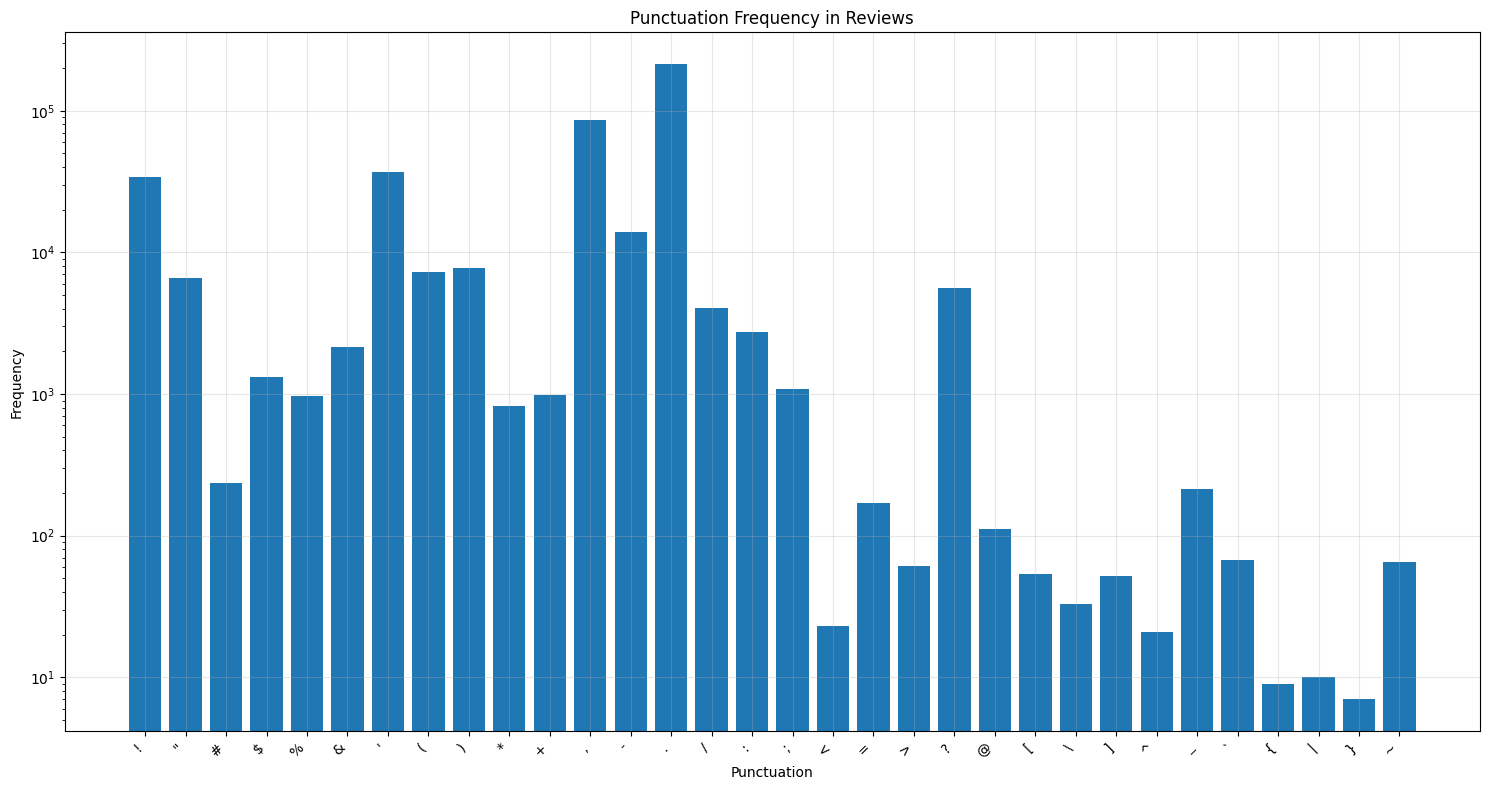

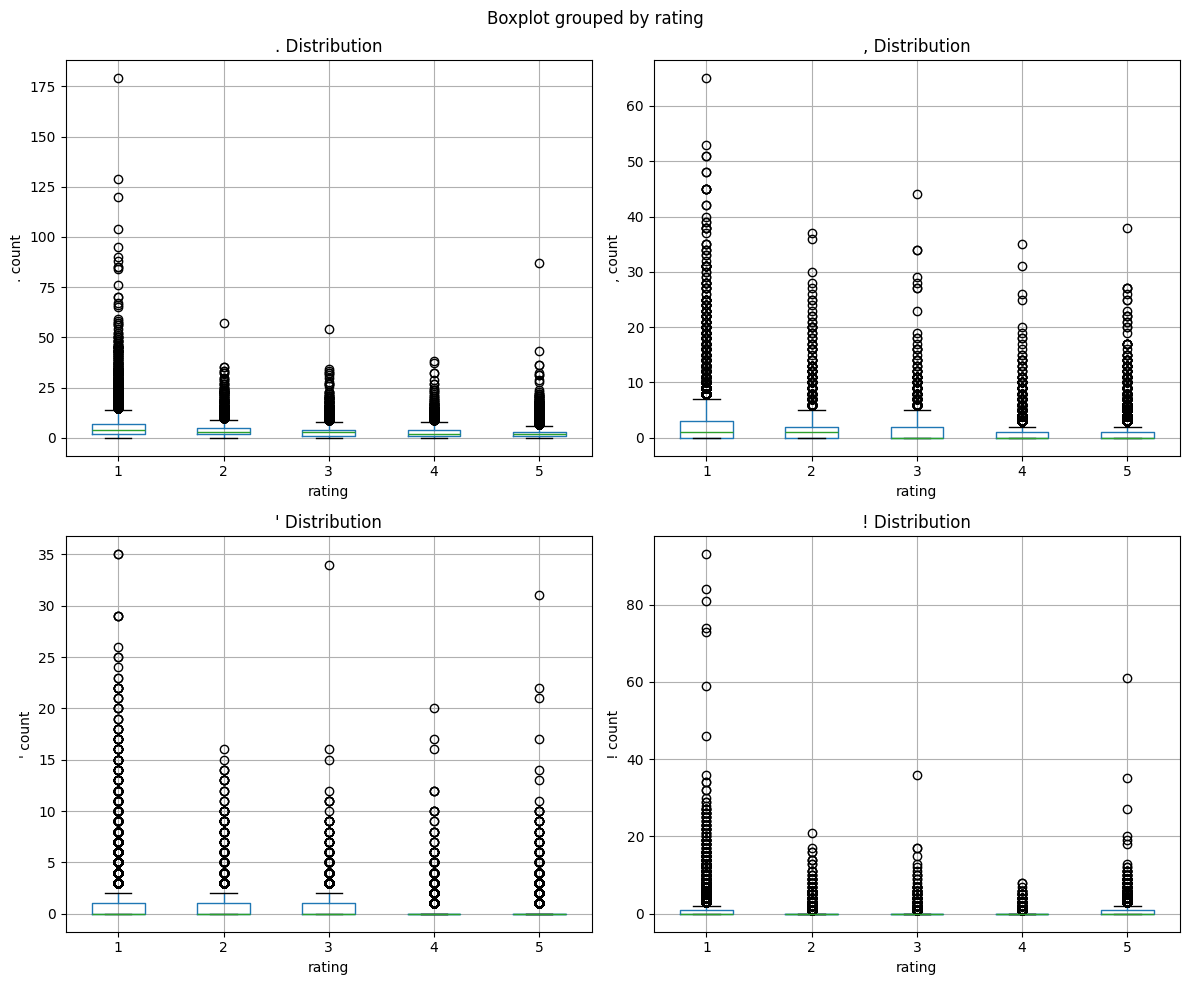

Average character length of text: 188.21 characters
Average character length of subject: 23.71 characters
Average word length of text: 27.16 words
Average word length of subject: 3.48 words

Most common words:
service: 27223
quicken: 22823
customer: 20670
great: 20042
asda: 17843
order: 15812
time: 14571
product: 14049
use: 13421
would: 12185
delivery: 11635
get: 11205
years: 10179
one: 8936
easy: 8932
flashbay: 8416
good: 8201
like: 8098
using: 7621
dont: 7543
support: 7264
work: 7062
used: 6991
back: 6879
never: 6300
helpful: 6282
even: 6248
online: 6241
got: 6125
still: 5893
ive: 5866
quick: 5832
could: 5829
items: 5800
help: 5747
company: 5604
shopping: 5570
store: 5517
experience: 5468
received: 5232
products: 5219
im: 5202
account: 5200
told: 5196
many: 5115
quality: 5062
fast: 5010
always: 4846
really: 4841
need: 4819
problem: 4788
refund: 4745
ordered: 4728
way: 4711
accounts: 4709
money: 4676
new: 4670
headset: 4658
go: 4585
process: 4548
day: 4538
days: 4505
issue: 4426
well:

In [17]:
#Basic text preprocessing
print("Original number of rows:", len(df_trustpilot))

#Removing the stop words
stop_words = set(stopwords.words('english'))

# Function to check if text is English
def is_english(text):
    try:
        if isinstance(text, str) and text.strip():
            return detect(text) == 'en'
        return False
    except:
        return False

# Remove non-English content from both text and subject columns
df_trustpilot['text_is_english'] = df_trustpilot['text'].apply(is_english)
df_trustpilot['subject_is_english'] = df_trustpilot['subject'].apply(is_english)

# Keep only rows where both text and subject are in English
df_trustpilot = df_trustpilot[df_trustpilot['text_is_english'] & df_trustpilot['subject_is_english']]
print("Number of rows after removing non-English content:", len(df_trustpilot))
df_trustpilot = df_trustpilot.drop(['text_is_english', 'subject_is_english'], axis=1)

# Email extraction
pat_mail = r'([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+)'
df_trustpilot['email'] = df_trustpilot['text'].str.extract(pat_mail, expand=False)

# Check unique emails found
print("Number of reviews containing emails:", df_trustpilot['email'].unique())

# URL extraction
pat_link = r'(https?://www.\w+\.\w{2,}/+\w{0,})'
df_trustpilot['link'] = df_trustpilot['text'].str.extract(pat_link, expand=False)

# Check unique links found
print("Number of reviews containing URLs:", df_trustpilot['link'].unique())

# List of punctuation marks to count
punctuation_marks = list(string.punctuation)

# Create new columns for each punctuation mark initialized to 0
for mark in punctuation_marks:
    df_trustpilot[f'punct_{mark}'] = 0

# Count punctuation marks in each text entry
for index, row in df_trustpilot.iterrows():
    text = row['text']
    for mark in punctuation_marks:
        df_trustpilot.at[index, f'punct_{mark}'] = text.count(mark)

# Define columns to exclude for punctuation analysis
exclude_cols = ['username', 'number_reviews', 'location', 'rating', 'text',
       'date_of_experience', 'date_posted', 'subject', 'answer', 'company',
       'verification', 'answered', 'local_hour', 'local_date_posted',
       'days_between_experience_and_post', 'day_of_week_posted']

# Get the columns to sum by excluding specified columns
include_cols = [col for col in df_trustpilot.columns if col.startswith('punct_')]

# Sum the values in the included columns
column_totals = df_trustpilot[include_cols].sum()

# Display punctuation statistics
print("\nPunctuation Statistics:")
print(column_totals.sort_values(ascending=False))

# Visualize punctuation counts
plt.figure(figsize=(15, 8))
plt.bar(column_totals.index.str.replace('punct_', ''), column_totals.values) 
plt.title("Punctuation Frequency in Reviews")
plt.xlabel("Punctuation")
plt.ylabel("Frequency")
plt.xticks(rotation=45, ha='right')
plt.yscale('log')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Update boxplot with top 4 most frequent punctuation marks
top_4_punct = column_totals.nlargest(4).index

# Display distribution of most frequent punctuations
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("Distribution of Common Punctuation Marks by Rating")

for idx, punct in enumerate(top_4_punct):
    i, j = divmod(idx, 2)
    df_trustpilot.boxplot(column=punct, by="rating", ax=axes[i,j])
    axes[i,j].set_ylabel(f"{punct.replace('punct_', '')} count")
    axes[i,j].set_title(f"{punct.replace('punct_', '')} Distribution")

plt.tight_layout()
plt.show()

# Function to remove stop words from a given text
def remove_stopwords(text):
    if isinstance(text, str):
        #Convert to lowercase
        text = text.lower()
        #Remove punctuation and special characters
        text = re.sub(r'[^\w\s]', '', text)
        #Properly tokenize the text
        words = word_tokenize(text)
        filtered_words = [word for word in words if word.lower() not in stop_words]
        return ' '.join(filtered_words)
    return text

# Rest of the original code continues as before...
df_trustpilot['text_processed'] = df_trustpilot['text'].apply(remove_stopwords)
df_trustpilot['subject_processed'] = df_trustpilot['subject'].apply(remove_stopwords)
df_trustpilot['answer_processed'] = df_trustpilot['answer'].apply(remove_stopwords)

# Calculate character length for both text and subject columns
df_trustpilot['text_length'] = df_trustpilot['text_processed'].apply(len)
df_trustpilot['subject_length'] = df_trustpilot['subject_processed'].apply(len)
average_length = df_trustpilot['text_length'].mean()
average_subject_length = df_trustpilot['subject_length'].mean()
print(f"Average character length of text: {average_length:.2f} characters")
print(f"Average character length of subject: {average_subject_length:.2f} characters")

# Calculate average word length
df_trustpilot['text_word_length'] = df_trustpilot['text_processed'].apply(lambda x: len(x.split()))
df_trustpilot['subject_word_length'] = df_trustpilot['subject_processed'].apply(lambda x: len(x.split()))
avg_text_words = df_trustpilot['text_word_length'].mean()
avg_subject_words = df_trustpilot['subject_word_length'].mean()
print(f"Average word length of text: {avg_text_words:.2f} words")
print(f"Average word length of subject: {avg_subject_words:.2f} words")

# Combining both text and subject for common words analysis
all_text = ' '.join(df_trustpilot['text_processed']) + ' ' + ' '.join(df_trustpilot['subject_processed'])
# Properly tokenize the combined text
words = word_tokenize(all_text.lower())
# Counting the frequency of each word
word_counts = Counter(words)
# Get the 500 most common words
common_words = word_counts.most_common(500)
# Displaying the common words
print("\nMost common words:")
for word, count in common_words:
    print(f"{word}: {count}")

0.18715539333695735
0.47265667469131006


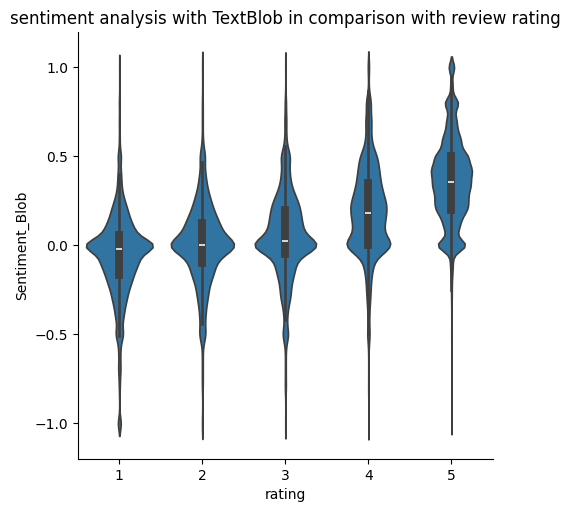

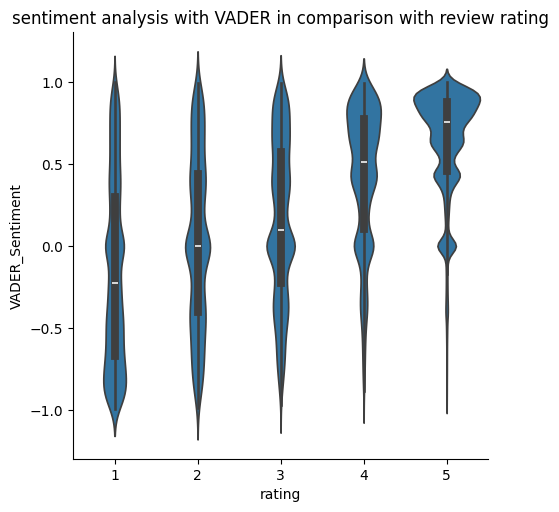

In [18]:
#Basic sentiment scores

#function returning the sentiment calculated by TextBlob
def sentiment_analysis(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity
# creating a new column with the sentiment from Text_blob
df_trustpilot['Sentiment_Blob'] = df_trustpilot['text_processed'].apply(lambda text: sentiment_analysis(str(text)))


sns.catplot(x="rating",y="Sentiment_Blob", kind="violin", data=df_trustpilot)
plt.title("sentiment analysis with TextBlob in comparison with review rating");


# Initialise VADER Sentiment-Analyzer
sia = SentimentIntensityAnalyzer()

# Function giving the VADER sentiment back
def vader_sentiment(text):
    sentiment_scores = sia.polarity_scores(text)
    return sentiment_scores['compound']

# creating new column with VADER_sentiment
df_trustpilot['VADER_Sentiment'] = df_trustpilot['text_processed'].apply(lambda text: vader_sentiment(str(text)))
df_trustpilot.head()



sns.catplot(x="rating",y="VADER_Sentiment", kind="violin", data=df_trustpilot)
plt.title("sentiment analysis with VADER in comparison with review rating");


# creating a new column with categorized values based on the TextBlob Sentiment
df_trustpilot["Sentiment_Blob_cat"]= pd.cut(df_trustpilot["Sentiment_Blob"], bins = [-1, -0.6, -0.2, 0.2, 0.6, 1], labels= [1, 2, 3, 4, 5])
df_trustpilot.head()


# creating a new column with categorized values based on the VADER Sentiment
df_trustpilot["Sentiment_VADER_cat"]= pd.cut(df_trustpilot["VADER_Sentiment"], bins = [-1, -0.6, -0.2, 0.2, 0.6, 1], labels= [1, 2, 3, 4, 5])
df_trustpilot.head()


# creating crosstabs of the actual rating compared to the rating comming from the TextBlob
cm = pd.crosstab(df_trustpilot.rating, df_trustpilot.Sentiment_Blob_cat, rownames = ["Rating"], colnames = ["Sentiment category from TextBlob"])
cm


# calculating true positives for TextBlob
TP_TextBlob = cm.loc[1,1]+cm.loc[2,2]+cm.loc[3,3]+cm.loc[4,4]+cm.loc[5,5]
total_num = df_trustpilot.shape[0]
TP_rate = TP_TextBlob/total_num
print(TP_rate)


# creating crosstabs of the actual rating compared to the rating comming from the VADER
cm = pd.crosstab(df_trustpilot.rating, df_trustpilot.Sentiment_VADER_cat, rownames = ["Rating"], colnames = ["Sentiment category from VADER"])
cm


# calculating true positives for VADER
TP_VADER = cm.loc[1,1]+cm.loc[2,2]+cm.loc[3,3]+cm.loc[4,4]+cm.loc[5,5]
total_num = df_trustpilot.shape[0]
TP_rate = TP_VADER/total_num
print(TP_rate)

In [ ]:
#Identifying words and phrases that might indicate positive or negative reviews

# creating a list of words and phrases to search in the review test
word_list = ['helpful', 'quick', 'recommend', 'friendly staff', 'great experience', 'fast delivery', 'quality products', 'exceeded expectations', 'very satisfied',
              'easy process', 'prompt response', 'support', 'quality', 'problem', 'attention to detail', 'reliable', 'easy to use', 'quick turnaround',
              'disappointing experience', 'poor quality', 'unreliable', 'overpriced', 'terrible service', 'unresponsive', 'excellent service', 'customer service',
                'poor customer service', 'waste of money', 'dissatisfied', 'unhelpful', 'frustrating', 'low quality', 'never again', 'disappointing', 'unprofessional',
                 'inconvenient', 'defective product', 'worth the price', 'great quality', 'poor communication', 'not satisfied']
len(word_list)


# create a new column in the DataFrame for each word or phrase containing the existing of the word in the test
for word in word_list:
    # Check if each word is in the 'text' column and convert to 1 for True, 0 for False
    df_trustpilot[word] = df_trustpilot['text_processed'].str.contains(fr'\b{word}\b', case=False, na=False).astype(int)

df_trustpilot.head()


included_cols = ['helpful', 'quick', 'recommend', 'friendly staff', 'great experience', 'fast delivery', 'quality products', 'exceeded expectations', 'very satisfied',
              'easy process', 'prompt response', 'support', 'quality', 'problem', 'attention to detail', 'reliable', 'easy to use', 'quick turnaround',
              'disappointing experience', 'poor quality', 'unreliable', 'overpriced', 'terrible service', 'unresponsive', 'excellent service', 'customer service',
                'poor customer service', 'waste of money', 'dissatisfied', 'unhelpful', 'frustrating', 'low quality', 'never again', 'disappointing', 'unprofessional',
                 'inconvenient', 'defective product', 'worth the price', 'great quality', 'poor communication', 'not satisfied']


# Sum the values in the included columns
column_totals = df_trustpilot[included_cols].sum().sort_values(ascending = True)

# Display the sum of each column
print(column_totals)


# counting the apperences of each word or phrase depending on the rating
result_df = df_trustpilot.groupby(["rating"])[included_cols].sum()
result_df


# considering, that the distribution of the rating is not even, calculating th total numbers of each rating
rating_counts = df_trustpilot['rating'].value_counts().sort_index()
print(rating_counts)


# normalizing the rating
normalized_counts = result_df.div(rating_counts, axis = 0)
normalized_counts_per = (normalized_counts*100).round(1)
normalized_counts_per


plt.figure(figsize=(20, 4))
sns.heatmap(normalized_counts_per, annot=True, cmap="YlGnBu")
plt.xlabel("Words and Phrases")
plt.ylabel("Rating")
plt.title("Percent of Word and Phrase Presence by Rating")
plt.show()

In [19]:
#Rearranging the order of the columns
print("Current column order:", df_trustpilot.columns.tolist())

display(df_trustpilot.head())

df_trustpilot = df_trustpilot[['rating', 'location', 'username', 'number_reviews', 'verification', 'verification_encoded', 'repeat_reviewer_encoded', 
                              'company', 'text', 'text_processed', 'text_length', 'text_word_length', 'subject', 'subject_processed', 'subject_length', 'subject_word_length', 'answer', 'answer_processed', 
                              'answered', 'date_of_experience', 'date_posted', 'local_date_posted',
                              'month_name_local_encoded', 'local_hour', 'time_of_day', 'time_of_day_encoded', 'day_of_week_posted', 
                               'day_type_encoded', 'days_between_experience_and_post', 'review_time_encoded']]

Current column order: ['username', 'number_reviews', 'location', 'rating', 'text', 'date_of_experience', 'date_posted', 'verification', 'subject', 'answer', 'company', 'local_hour', 'local_date_posted', 'days_between_experience_and_post', 'day_of_week_posted', 'answered', 'time_of_day', 'verification_encoded', 'day_type_encoded', 'time_of_day_encoded', 'month_name_local_encoded', 'repeat_reviewer_encoded', 'review_time_encoded', 'punct_!', 'punct_"', 'punct_#', 'punct_$', 'punct_%', 'punct_&', "punct_'", 'punct_(', 'punct_)', 'punct_*', 'punct_+', 'punct_,', 'punct_-', 'punct_.', 'punct_/', 'punct_:', 'punct_;', 'punct_<', 'punct_=', 'punct_>', 'punct_?', 'punct_@', 'punct_[', 'punct_\\', 'punct_]', 'punct_^', 'punct__', 'punct_`', 'punct_{', 'punct_|', 'punct_}', 'punct_~', 'text_processed', 'subject_processed', 'answer_processed', 'text_length', 'subject_length', 'text_word_length', 'subject_word_length', 'Sentiment_Blob', 'VADER_Sentiment', 'Sentiment_Blob_cat', 'Sentiment_VADER_cat

,username,number_reviews,location,rating,text,date_of_experience,date_posted,verification,subject,answer,company,local_hour,local_date_posted,days_between_experience_and_post,day_of_week_posted,answered,time_of_day,verification_encoded,day_type_encoded,time_of_day_encoded,month_name_local_encoded,repeat_reviewer_encoded,review_time_encoded,punct_!,"punct_""",punct_#,punct_$,punct_%,punct_&,punct_',punct_(,punct_),punct_*,punct_+,"punct_,",punct_-,punct_.,punct_/,punct_:,punct_;,punct_<,punct_=,punct_>,punct_?,punct_@,punct_[,punct_\,punct_],punct_^,punct__,punct_`,punct_{,punct_|,punct_},punct_~,text_processed,subject_processed,answer_processed,text_length,subject_length,text_word_length,subject_word_length,Sentiment_Blob,VADER_Sentiment,Sentiment_Blob_cat,Sentiment_VADER_cat
0,Rob Crane,2,CA,5,The company rep I worked with made my transact...,2024-06-15,2024-10-23 04:17:44,Redirected,The company rep I worked with made my…,0,Flashbay,21,2024-10-22,129,1,0,Evening,0,1,2,10,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,company rep worked made transaction smooth qui...,company rep worked made,0,110,23,15,4,0.311111,0.4215,4,4
1,Pat Anderson,1,US,5,I highly recommend using Flashbay. Immediately...,2024-10-16,2024-10-16 19:34:05,Verified,I highly recommend using Flashbay,0,Flashbay,12,2024-10-16,0,2,0,Business Hours,1,1,3,10,0,1,2,0,0,0,0,0,1,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,highly recommend using flashbay immediately or...,highly recommend using flashbay,0,202,31,26,4,0.345417,0.6233,4,5
2,Margarita Orlova,1,CZ,5,I had the pleasure of working with Shelby Gibs...,2024-10-10,2024-10-17 10:27:44,Verified,Great customer service,0,Flashbay,10,2024-10-17,7,3,0,Business Hours,1,1,3,10,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,pleasure working shelby gibson large order nee...,great customer service,0,175,22,24,3,0.320223,0.9643,4,5
3,Paola Rivas,1,US,5,I had a fantastic experience with Brian Truong...,2024-10-21,2024-10-21 22:38:50,Verified,Outstanding Support and Attentive Service,0,Flashbay,15,2024-10-21,0,0,0,Business Hours,1,1,3,10,0,1,1,0,0,0,0,0,0,0,0,0,0,2,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,fantastic experience brian truong attentive tr...,outstanding support attentive service,0,122,37,14,4,0.600000,0.9169,4,5
4,Fiona Mckelvey Keenan,3,CA,5,My number-one go-to for computer accessories. ...,2024-07-11,2024-10-23 04:09:05,Not Verified,My number-one go-to for computer…,0,Flashbay,21,2024-10-22,103,1,0,Evening,0,1,2,10,1,0,1,0,0,0,0,0,0,0,0,0,0,1,2,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,numberone goto computer accessories rachel sup...,numberone goto computer,0,155,23,18,3,0.386667,0.8553,4,5


In [20]:
#Last check
print(df_trustpilot.columns)
print(df_trustpilot.info())
display(df_trustpilot.head())

Index(['rating', 'location', 'username', 'number_reviews', 'verification',
       'verification_encoded', 'repeat_reviewer_encoded', 'company', 'text',
       'text_processed', 'text_length', 'text_word_length', 'subject',
       'subject_processed', 'subject_length', 'subject_word_length', 'answer',
       'answer_processed', 'answered', 'date_of_experience', 'date_posted',
       'local_date_posted', 'month_name_local_encoded', 'local_hour',
       'time_of_day', 'time_of_day_encoded', 'day_of_week_posted',
       'day_type_encoded', 'days_between_experience_and_post',
       'review_time_encoded'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Index: 64385 entries, 0 to 78403
Data columns (total 30 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   rating                            64385 non-null  int64         
 1   location                          64385 non-null  

,rating,location,username,number_reviews,verification,verification_encoded,repeat_reviewer_encoded,company,text,text_processed,text_length,text_word_length,subject,subject_processed,subject_length,subject_word_length,answer,answer_processed,answered,date_of_experience,date_posted,local_date_posted,month_name_local_encoded,local_hour,time_of_day,time_of_day_encoded,day_of_week_posted,day_type_encoded,days_between_experience_and_post,review_time_encoded
0,5,CA,Rob Crane,2,Redirected,0,1,Flashbay,The company rep I worked with made my transact...,company rep worked made transaction smooth qui...,110,15,The company rep I worked with made my…,company rep worked made,23,4,0,0,0,2024-06-15,2024-10-23 04:17:44,2024-10-22,10,21,Evening,2,1,1,129,0
1,5,US,Pat Anderson,1,Verified,1,0,Flashbay,I highly recommend using Flashbay. Immediately...,highly recommend using flashbay immediately or...,202,26,I highly recommend using Flashbay,highly recommend using flashbay,31,4,0,0,0,2024-10-16,2024-10-16 19:34:05,2024-10-16,10,12,Business Hours,3,2,1,0,1
2,5,CZ,Margarita Orlova,1,Verified,1,0,Flashbay,I had the pleasure of working with Shelby Gibs...,pleasure working shelby gibson large order nee...,175,24,Great customer service,great customer service,22,3,0,0,0,2024-10-10,2024-10-17 10:27:44,2024-10-17,10,10,Business Hours,3,3,1,7,0
3,5,US,Paola Rivas,1,Verified,1,0,Flashbay,I had a fantastic experience with Brian Truong...,fantastic experience brian truong attentive tr...,122,14,Outstanding Support and Attentive Service,outstanding support attentive service,37,4,0,0,0,2024-10-21,2024-10-21 22:38:50,2024-10-21,10,15,Business Hours,3,0,1,0,1
4,5,CA,Fiona Mckelvey Keenan,3,Not Verified,0,1,Flashbay,My number-one go-to for computer accessories. ...,numberone goto computer accessories rachel sup...,155,18,My number-one go-to for computer…,numberone goto computer,23,3,0,0,0,2024-07-11,2024-10-23 04:09:05,2024-10-22,10,21,Evening,2,1,1,103,0


In [21]:
import os

os.makedirs('data', exist_ok=True)

csv_path = 'data/data_trustpilot.csv'
df_trustpilot.to_csv(csv_path, index=False)
print(f"DataFrame exported to {csv_path}")

DataFrame exported to data/data_trustpilot.csv
